<a href="https://colab.research.google.com/github/ugThaminduD/DL__SE4050__Lab7/blob/main/Deep_Q_Learning_GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [ ]:
class GridWorld:
    def __init__(self, height=10, width=10):
        self.height = height
        self.width = width
        self.grid = np.zeros((height, width)) - 1

        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        self.grid[self.bomb_location] = -10
        self.grid[self.gold_location] = 10

        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.reset()

    def reset(self):
        self.current_location = (np.random.randint(0, self.height), np.random.randint(0, self.width))
        while self.current_location in self.terminal_states:
            self.current_location = (np.random.randint(0, self.height), np.random.randint(0, self.width))
        return self.current_location

    def get_available_actions(self):
        return self.actions

    def get_reward(self, location):
        return self.grid[location[0], location[1]]

    def make_step(self, action):
        last_location = self.current_location
        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)
        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'
        return None

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.FloatTensor(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=0.1, alpha=0.001, gamma=0.99, buffer_size=10000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size

        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.update_target()

        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
        self.replay_buffer = ReplayBuffer(buffer_size)

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state_arr = np.array(state).flatten() / 10.0
        q_values = self.model(state_arr)
        return torch.argmax(q_values).item()

    def store(self, state, action, reward, next_state, done):
        state_arr = np.array(state).flatten() / 10.0
        next_state_arr = np.array(next_state).flatten() / 10.0
        self.replay_buffer.push(state_arr, action, reward, next_state_arr, done)

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_model(next_states)
            next_q_value = torch.max(next_q_values, dim=1)[0]
            expected_q = rewards + self.gamma * next_q_value * (1 - dones)

        loss = nn.functional.mse_loss(q_value, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
def train_dqn(epsilon, episodes=500, env_size=10):
    env = GridWorld(height=env_size, width=env_size)
    agent = DQNAgent(state_dim=2, action_dim=4, epsilon=epsilon)
    rewards = []

    update_target_every = 50

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False
        while not done and steps < 3000:
            action = agent.select_action(state)
            action_str = env.actions[action]
            reward = env.make_step(action_str)
            next_state = env.current_location
            done = env.check_state() == 'TERMINAL'
            agent.store(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        rewards.append(total_reward)
        if ep % update_target_every == 0:
            agent.update_target()
    return rewards

Training DQN with epsilon=0.1
Training DQN with epsilon=0.5
Training DQN with epsilon=0.9


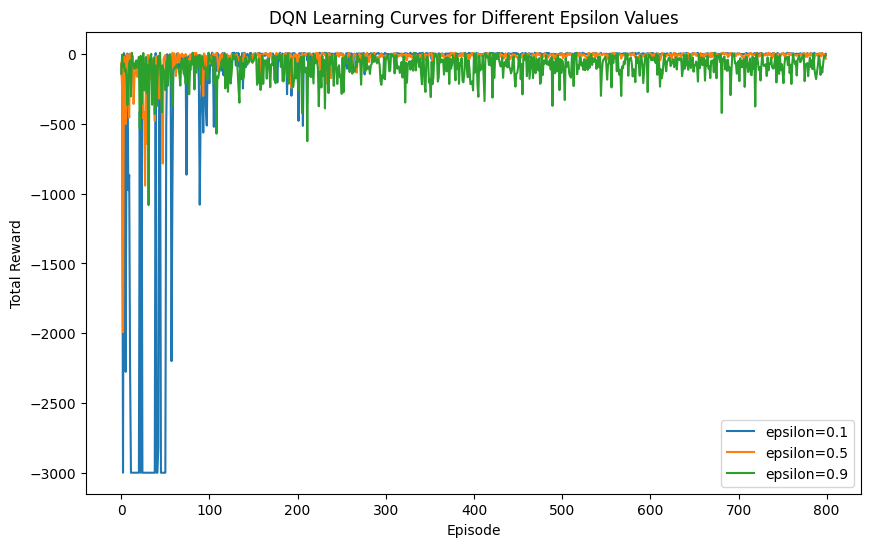

In [ ]:
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    print(f"Training DQN with epsilon={eps}")
    rewards = train_dqn(epsilon=eps, episodes=800, env_size=10)
    results[eps] = rewards

plt.figure(figsize=(10,6))
for eps in epsilons:
    plt.plot(results[eps], label=f"epsilon={eps}")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Learning Curves for Different Epsilon Values")
plt.legend()
plt.show()

Observation -

0.1- Agent explores very little, learns stable policy quickly but may miss better paths. And fast covergence (picks best-known action)

0.5- This gives a good balance, stable learning and better final policy.

0.9- Learns slower because it explores too much (random actions), but eventually reaches high performance.


Epsilon often decayed over time :
* explore early and exploit later as the model learns better policies.